In [2]:
try:
    import micropip
    await micropip.install("matplotlib")
except ImportError:
    pass
%pylab inline
import tqdm

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Stability of a discretized linear (stochatic) delay differential equation

To get started, let's use a linear stochastic delay differential equation (SDDE), parameterized by `D` the number of steps for the delay,

\begin{align}
\dot{x}(t) &= -l \: x(t) - y(t) + k \: y(t - D/dt) \\
\dot{y}(t) &= -l \: y(t) + x(t)
\end{align}

## Simulation w/ Euler-Maruyama scheme

([<matplotlib.lines.Line2D at 0x7f0323619f00>,
 None)

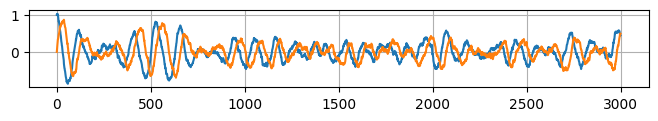

In [3]:
def run(D):
    T = 3000
    #D = 50
    dt = 0.05
    l = 0.05
    k = 0.2

    np.random.seed(42)
    z = np.random.randn(T-1,2)*np.sqrt(dt)*1e-1
    x = np.zeros((T,2))
    x[0,0] = 1.0
    for t in range(T-1):
        dx = np.r_[-l*x[t,0] - x[t,1], -l*x[t,1] + x[t,0]]
        if t > D:
            dx[0] += k*x[t-D,1]
        x[t+1] = x[t] + dt*dx + z[t]
    return x
x = run(50)
figure(figsize=(8,1)); plot(x), grid(1)

## Numerical stability

We can check how stable it is for varying delays,

In [4]:
vs = []
ds = np.r_[5:450:10]
for d in tqdm.tqdm(ds):
    x = run(d)
    v = np.diff( np.abs(x).reshape((30,-1)).mean(axis=1) ).mean()
    vs.append(v)


100%|███████████████████████████████████████████████████████████████████████████| 45/45 [00:02<00:00, 21.18it/s]


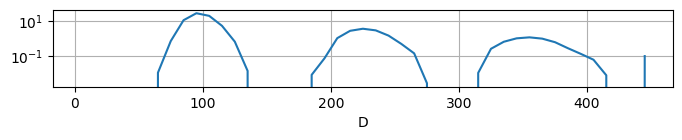

In [15]:
figure(figsize=(8,1)); semilogy(ds,vs); grid(1); xlabel('D');

## Analytic stability

Given the Euler discretization, we can make a discrete time linear system which shows the same thing

In [5]:
# D = 15
def linstab(D):
    L = np.zeros((2+D,2+D))
    dt = 0.05
    l = 0.05
    k = 0.2

    L[0,0] = 1-dt*l # x <- x
    L[0,1] = -dt # x <- y
    L[1,1] = 1-dt*l # y <- y
    L[1,0] = dt # y <- x
    L[0,-1] = dt*k # x <- delayed y
    for i in range(D):
        L[2+i,1+i] = 1.0 # store y value

    return L # 

In [45]:
ls = []
ds = np.r_[5:450:10]
for d in tqdm.tqdm(ds):
    L = linstab(d)
    ls.append( np.abs(eig(L)[0]).max() )

100%|███████████████████████████████████████████████████████████████████████████| 45/45 [00:05<00:00,  7.77it/s]


/tmp/ipykernel_63214/348161656.py:3: RuntimeWarning: invalid value encountered in log
  subplot(212); plot(ds, np.log(vs)); xlim([5, 450]); grid(1); xlabel('D');


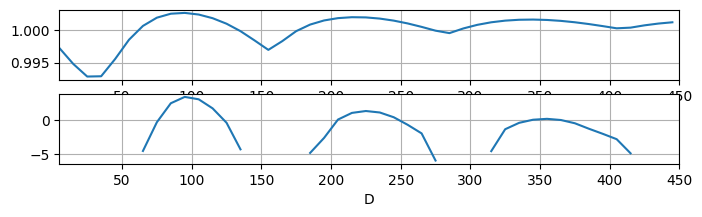

In [46]:
figure(figsize=(8,2))
subplot(211); plot(ds, ls); xlim([5, 450]); grid(1);
subplot(212); plot(ds, np.log(vs)); xlim([5, 450]); grid(1); xlabel('D');

This verifies we can predict stability of the delayed system by its discrete stability.
Well, we already knew that, rather this checks that the matrix constructed has stability matching our SDDE. 

## Simulation via matrix application

We can also check that the matrix constructed above results in the same simulation as the SDDE discretization,

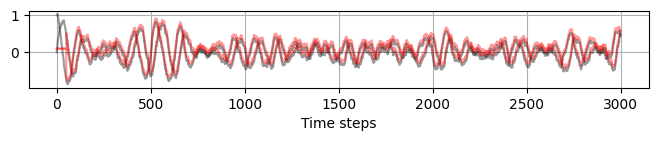

In [8]:
def run2(D):
    T = 3000
    #D = 50
    dt = 0.05
    l = 0.05
    k = 0.2
    
    # construct linear system
    L = linstab(D)

    # sample noise
    np.random.seed(42)
    z = np.random.randn(T-1,2)*np.sqrt(dt)*1e-1
    
    # simulate SDDE w/ EM scheme
    x = np.zeros((T,2))
    x[0,0] = 1.0
    for t in range(T-1):
        dx = np.r_[-l*x[t,0] - x[t,1], -l*x[t,1] + x[t,0]]
        if t > D:
            dx[0] += k*x[t-D,1]
        x[t+1] = x[t] + dt*dx + z[t]
        
    # simulate SDDE with discrete time L
    x2 = np.zeros((T,2))
    x[0,0] = 1.0
    for t in range(D,T-1):
        x2[t+1] = (L @ (np.r_[x[t], x[t-D:t,1]]))[:2] + z[t]
    return x, x2

x, x2 = run2(50)
figure(figsize=(8,1)); plot(x, 'k', alpha=0.4), plot(x2+0.1, 'r', alpha=0.4), grid(1); xlabel('Time steps');

*a small vertical shift is applied in order to see both lines*

## interpreting eigenvectors of a discretized delay system

One of the goals of this exercise is to see how to approximate the behavior of the full system by a few eigenmodes.

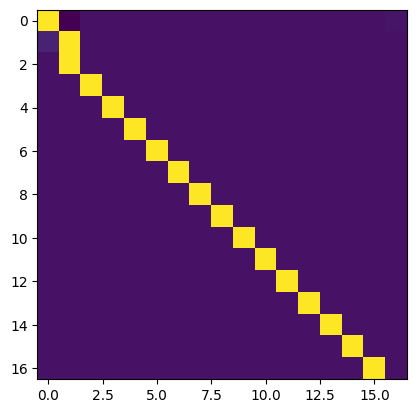

In [9]:
L = linstab(D=15)
imshow(L)

In [10]:
e, v = np.linalg.eig(L)
# sort_e = np.argsort(e.real)[::-1]  # descending real part
# e, v = e[sort_e], v[:,sort_e]

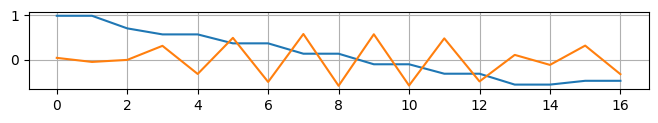

In [11]:
figure(figsize=(8,1)); plot(e.real);plot(e.imag); grid(1); 

nb. for a discrete system, stability is for magnitude (pos or neg) real part < 1, unlike for continuous system where real part must be negative.

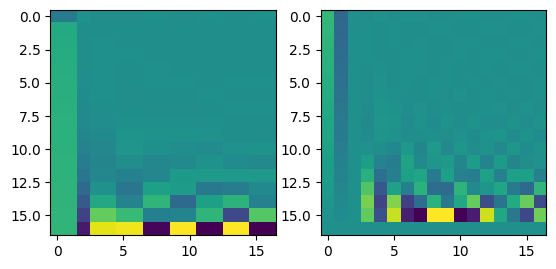

In [12]:
subplot(121); imshow(v.real)
subplot(122); imshow(v.imag)

Before trying to project to eigenmodes, we could expand the real time series in terms of the discrete system,

In [13]:
x.shape

(3000, 2)

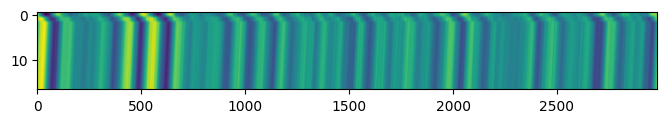

In [14]:
D = L.shape[0] - 2
X = []
for t in range(D, x.shape[0]-1):
    X.append( np.r_[x[t], x[t-D:t,1]] )
X = np.array(X)

figure(figsize=(8,1)); imshow(X.T, aspect='auto')

The slight tilt is the state values moving through the delay buffer.

Then, plot the time series of the modes scaled by eigen value to see relative contributions,

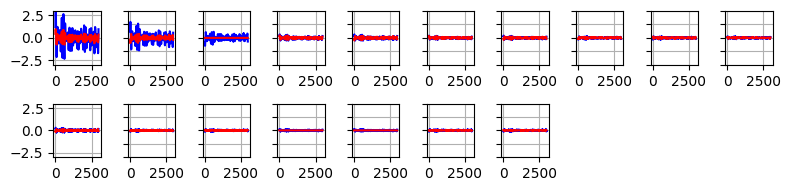

In [15]:
figure(figsize=(8,2))
for i in range(v.shape[1]):
    xi = np.abs(e[i]) * (X @ v[:,i])
    subplot(2, 10, i+1); plot(xi.real, 'b'); plot(xi.imag, 'r'); grid(1); ylim([-3, 3])
    if (i%10)!=0: yticks(yticks()[0], [])
tight_layout()

As expected, a few modes account for most of the variance, so how well can the eigenvectors reconstruct the time series. 

*WAIT* eigenvectors are only orthogonal for symmetric matrices:

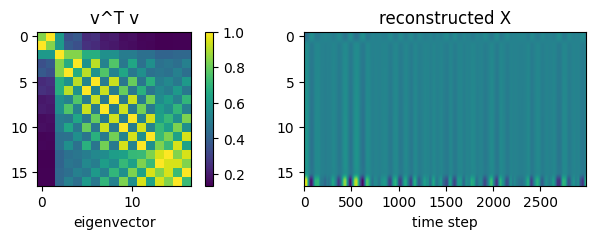

In [16]:
figure(figsize=(8, 2))
subplot(121); imshow(np.abs( v.T @ v )); colorbar(); xlabel('eigenvector');  title( 'v^T v') 
subplot(122); imshow(((X @ v) @ v.T).T.real, aspect='auto'); xlabel('time step'); title('reconstructed X');

Let's try a QR on v,

In [17]:
q, r = np.linalg.qr(v)

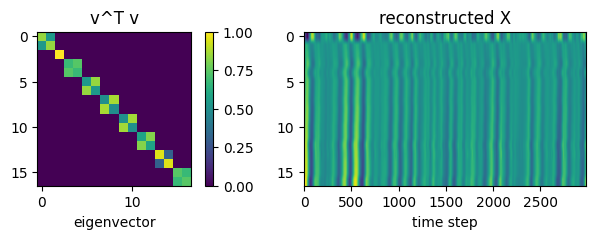

In [18]:
figure(figsize=(8, 2))
subplot(121); imshow(np.abs( q.T @ q )); colorbar(); xlabel('eigenvector');  title( 'v^T v') 
subplot(122); imshow(((X @ q) @ q.T).T.real, aspect='auto'); xlabel('time step'); title('reconstructed X');

That's closer. What do the reconstructed time series look like?

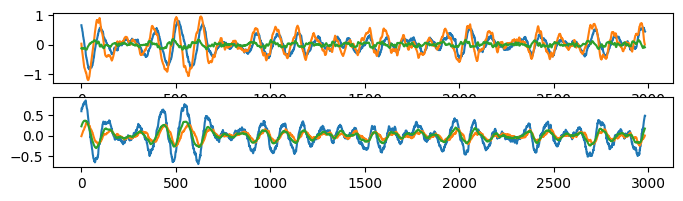

In [25]:
figure(figsize=(8,2));
m = 5
q, r = np.linalg.qr(v[:,:m])
rx = ((X @ q) @ q.T)
subplot(211); plot(x[D:,0]); plot(rx[:,0].real);plot(rx[:,0].imag);
subplot(212); plot(x[D:,1]); plot(rx[:,1].real);plot(rx[:,1].imag);

## stability of reduced system

If the reconstruction presents some error, it makes sense to ask if the stability of the linear system in mode space has the same stability as in the full space,

In [56]:
def redlinstab(L, m=5):
    e, v = np.linalg.eig(L)           # eigenspace of L
    q, r = np.linalg.qr(e[:m]*v[:,:m])      # ortho basis for L
    qL = (q.T @ (L @ q))              # action of L in q space
    return qL

def reduced_stability(L, m=5):
    qL = redlinstab(L, m=m)
    e, v = np.linalg.eig(qL)          # stability of qL    
    return np.abs(e).max()

In [110]:
ls = []
ds = np.r_[50:350:2]
for d in tqdm.tqdm(ds):
    L = linstab(d)
    e, v = np.linalg.eig(v)
    l = []
    l.append( np.abs(eig(L)[0]).max() )
    for m in [2, 3, 4, 5]:
        l.append(reduced_stability(L, m))
    ls.append(l)
ls = np.array(ls); ls.shape

100%|█████████████████████████████████████████████████████████████████████████| 150/150 [01:11<00:00,  2.09it/s]


(150, 5)

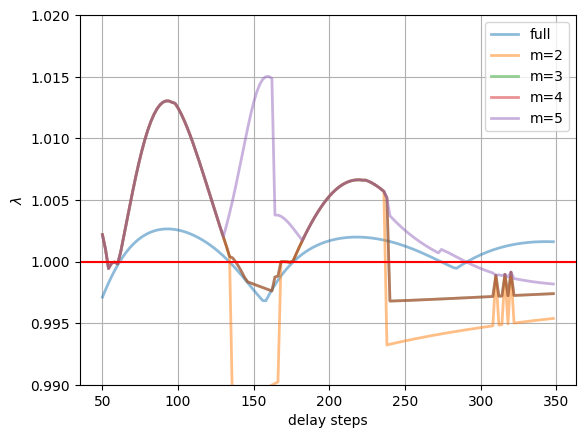

In [124]:
plot(ds, ls, linewidth=2, alpha=0.5)
legend(('full', 'm=2', 'm=3', 'm=4', 'm=5'))
axhline(1.0, color='r')
grid(1), xlabel('delay steps'), ylabel('$\lambda$'), ylim([0.99, 1.02]);

Some features of full stability seem preserved but not clear why increasing the number of modes to 5 results in loss of stability.

A next step would be to assess forward prediction error.